Connect to google drive

Weights and Bias platform login

In [2]:
!pip install -qq wandb
import wandb

wandb.login(key='02c241f212f9509dfc9047b0520a9f402b4e4f6d')

ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

conda 4.10.1 requires ruamel_yaml_conda>=0.11.14, which is not installed.
requests 2.24.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.11 which is incompatible.
c:\Users\Acer\anaconda3\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: arunbaby. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your ap

True

Balanced: [0.9664603471755981, 0.999772846698761, 0.4072933495044708]
<br>Object split: [0.7557615041732788, 0.9998406171798706, 0.2916567027568817]

In [2]:
import h5py
from glob import glob
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
tqdm.pandas()

##Reading and filtering data

###Data loading
The data is loadded from .h5 files for each object

In [3]:
columns_x = []
columns_y = []
columns_z = []

for i in range(18):
    columns_x.append(f'{i}_x')
    columns_y.append(f'{i}_y')
    columns_z.append(f'{i}_z')

experiment_columns_initial = ['Object', 'Pose', 'Experiment', 'Length', 'Accepted']

frames = []
lens = []
rejects = 0
accepts = 0

exp_df_1 = pd.DataFrame(columns=experiment_columns_initial)

print('Reading experiment data from h5 files')
# for file_path in tqdm(glob('/content/drive/Othercomputers/My Laptop (1)/MSc Project/Codebase/Data/tactile_object_recognition/*.h5')):
for file_path in tqdm(glob('Data/tactile_object_recognition/*.h5')):
    hf = h5py.File(file_path, 'r')
    name = list(hf.keys())[0]
    poses = list(hf[name].keys())
    for pose in poses:
        experiments = list(hf[f'{name}/{pose}'].keys())
        for experiment in experiments:
            path = f'{name}/{pose}/{experiment}'
            df_x = pd.DataFrame(np.array(hf[f'{path}/tactile_data_normalized/x']).T, columns=columns_x)
            df_y = pd.DataFrame(np.array(hf[f'{path}/tactile_data_normalized/y']).T, columns=columns_y)
            df_z = pd.DataFrame(np.array(hf[f'{path}/tactile_data_normalized/z']).T, columns=columns_z)

            result = pd.concat([df_x, df_y, df_z], axis=1, join="inner")

            result['timestamp'] = np.array(hf[f'{path}/tactile_timestamps'])
            result['change_label'] = np.array(hf[f'{path}/tactile_changes_label'])

            exp_length = (len(result)/180)
            lens.append(exp_length)
            if exp_length < 15:
                rejects = rejects + 1
                is_in = False
            else:
                is_in = True
                accepts = accepts + 1
                result['object'] = name
                result['pose'] = pose
                result['experiment'] = experiment
                frames.append(result)

            exp_df_1.loc[len(exp_df_1)] = [name, pose, experiment, exp_length, is_in]
            
    hf.close()
df = pd.concat(frames)
print(f'{accepts} experiments accepted out of {len(lens)}')

objects = df.object.unique()
weights = [28.0,165.0,24.0,210.0,16.0,78.0,125.0,227.0,127.0,62.0]

weight_df = pd.DataFrame()

weight_df['object'] = objects
weight_df['Weights'] = weights

weight_df
final_df = df.merge(weight_df, left_on='object', right_on='object')


Reading experiment data from h5 files



426 experiments accepted out of 571


###Data cleaning
The dataset contains data from unwanted phases of the experiment. The rows from lift phase is extracted and invalid experiments are removed.

In [4]:
count = 0
selected_count = 0
selected = []

exp_df_2 = pd.DataFrame(columns=['Object', 'Pose', 'Experiment', 'Accepted', 'Note'])

pose_count = []
count_1 = []
print('Extracting lift phase and rejecting invalid experiments...')
for object in tqdm(objects):
    object_df = final_df.loc[final_df['object'] == object]
    poses = object_df.pose.unique()
    pose_count.append(len(poses))
    #print(f'Object {object} has {len(poses)} poses')
    for pose in poses:
        pose_df = object_df[object_df['pose'] == pose]
        experiments = pose_df.experiment.unique()
        count_2 = 0
        for experiment in experiments:
            exp_df = pose_df[pose_df['experiment']==experiment].copy()
            count = count + 1
            
            #Getting rolling mean to 20
            exp_df['rolling_mean'] = exp_df['change_label'].rolling(window=20).mean()
            
            #Gettin strips of 0s on rolling mean
            idx_pairs = np.where(np.diff(np.hstack(([False],exp_df['rolling_mean'] ==0,[False]))))[0].reshape(-1,2)

            #Get length of strips
            lengths = np.diff(idx_pairs,axis=1).flatten()

            #Removing strips less that 100 samples long
            idx_pairs = idx_pairs[lengths>100]

            #Check if strips are over 10 seconds
            if((len(lengths[lengths > 1800])>0)):
                exp_df_2.loc[len(exp_df_2)] = [object, pose, experiment, False, 'Strip too long' ]
                print(object, pose, experiment, False, 'Strip too long')
                continue
            #Check if there are less than 2 long strips
            elif((len(idx_pairs)<2)):
                exp_df_2.loc[len(exp_df_2)] = [object, pose, experiment, False, 'Less than 2 strips' ]
                continue
            else:
                selected_count = selected_count + 1

                #Getting the longest 4 strips
                if(len(idx_pairs)>3):
                    longest_4 = np.flip(np.argpartition(np.diff(idx_pairs,axis=1).flatten(), -4)[-4:])
                    longest_4_idx = idx_pairs[longest_4]
                else:
                    longest_4_idx = idx_pairs

                #Arranging strips by time, earlier first
                a = longest_4_idx.tolist() 
                longest_4_idx = np.array(sorted(a, key=lambda a_entry: a_entry[0]))

                #Getting dataframe index
                longest_4_idx = longest_4_idx + exp_df.index[0]

                #Initializing lift phase column
                exp_df['lift'] = False
                
                #Getting the second strip location
                lift_start = longest_4_idx[1][0]
                lift_end = longest_4_idx[1][1]

                #Setting the lift areas to ture
                exp_df.loc[lift_start:lift_end, 'lift'] =  True
                #If small interruption during lift, add the rest of the portion too
                remark = 'Normal'
                if(len(longest_4_idx)>2):
                    next_break_length = longest_4_idx[2][0]-longest_4_idx[1][1]
                    next_break_mean = exp_df.loc[longest_4_idx[1][1]: longest_4_idx[2][0], "rolling_mean"].mean()
                    if((next_break_length<90) and (next_break_mean<0.4)):
                        lift_start = longest_4_idx[2][0]
                        lift_end = longest_4_idx[2][1]
                        exp_df.loc[lift_start:lift_end, 'lift'] =  True
                        remark = 'Appended tail'
                count_2 = count_2 + 1 
                exp_df_2.loc[len(exp_df_2)] = [object, pose, experiment, True, remark ]
                selected.append(exp_df.drop(['rolling_mean'], axis=1))
            count_1.append(count_2)  

print(f'Selected {selected_count} out of {count} experiments')

cleaned_df = pd.concat(selected)
experiments_df = cleaned_df.loc[cleaned_df['lift']].drop([ 'lift', 'timestamp', 'change_label'], axis=1).copy()
lift_only = cleaned_df.loc[cleaned_df['lift']].drop(['lift', 'timestamp', 'change_label', 'object', 'pose', 'experiment'], axis=1)

Extracting lift phase and rejecting invalid experiments...


adversarialPipe Pose3 Exp9 False Strip too long
adversarialPipe Pose4 Exp11 False Strip too long
adversarialPipe Pose4 Exp14 False Strip too long
adversarialPipe Pose4 Exp15 False Strip too long
adversarialPipe Pose4 Exp2 False Strip too long
adversarialPipe Pose4 Exp4 False Strip too long
adversarialPipe Pose4 Exp6 False Strip too long
adversarialPipe Pose4 Exp8 False Strip too long
legoDuplo Pose1 Exp15 False Strip too long
marbleNet Pose2 Exp6 False Strip too long
marbleNet Pose5 Exp8 False Strip too long
marbleNet Pose5 Exp9 False Strip too long
metalBox Pose3 Exp15 False Strip too long
teddyBear Pose1 Exp12 False Strip too long
teddyBear Pose1 Exp13 False Strip too long
teddyBear Pose2 Exp11 False Strip too long
teddyBear Pose2 Exp13 False Strip too long
teddyBear Pose2 Exp2 False Strip too long
teddyBear Pose2 Exp8 False Strip too long
teddyBear Pose2 Exp9 False Strip too long
teddyBear Pose3 Exp5 False Strip too long
teddyBear Pose3 Exp7 False Strip too long
teddyBear Pose3 Exp8

In [6]:
balanced_df = experiments_df.drop(experiments_df[experiments_df.Weights == 24.0].index).drop(experiments_df[experiments_df.Weights == 227.0].index)

In [5]:
experiments_df

0_x  1_x  2_x  3_x  4_x  5_x   6_x  7_x  8_x  9_x  ...  12_z  13_z  \
1126     0.0  0.0  0.0 -2.0 -1.0  0.0  21.0  6.0  0.0  0.0  ...   0.0   0.0   
1127     0.0  0.0  0.0 -2.0 -1.0  0.0  21.0  6.0  0.0  0.0  ...   0.0   0.0   
1128     0.0  0.0  0.0 -2.0 -1.0  0.0  21.0  6.0  0.0  0.0  ...   0.0   0.0   
1129     0.0  0.0  0.0 -2.0 -1.0  0.0  21.0  6.0  0.0  0.0  ...   0.0   0.0   
1130     0.0  0.0  0.0 -2.0 -1.0  0.0  21.0  6.0  0.0  0.0  ...   0.0   0.0   
...      ...  ...  ...  ...  ...  ...   ...  ...  ...  ...  ...   ...   ...   
1531054  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0 -6.0  ...  90.0   1.0   
1531055  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0 -6.0  ...  90.0   1.0   
1531056  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0 -6.0  ...  90.0   1.0   
1531057  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0 -6.0  ...  90.0   1.0   
1531058  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0 -6.0  ...  90.0   1.0   

         14_z  15_z  16_z  17_z           object   pose  experiment  Weights  
1126      0.0   0.0   0.0   0.0  adversarialPipe  Pose1       Exp14     28.0  
1127      0.0   0.0   0.0   0.0  adversarialPipe  Pose1       Exp14     28.0  
1128      0.0   0.0   0.0   0.0  adversarialPipe  Pose1       Exp14     28.0  
1129      0.0   0.0   0.0   0.0  adversarialPipe  Pose1       Exp14     28.0  
1130      0.0   0.0   0.0   0.0  adversarialPipe  Pose1       Exp14     28.0  
...       ...   ...   ...   ...              ...    ...         ...      ...  
1531054   0.0  96.0   8.0   0.0       tennisBall  Pose5        Exp9     62.0  
1531055   0.0  96.0   8.0   0.0       tennisBall  Pose5        Exp9     62.0  
1531056   0.0  96.0   8.0   0.0       tennisBall  Pose5        Exp9     62.0  
1531057   0.0  96.0   8.0   0.0       tennisBall  Pose5        Exp9     62.0  
1531058   0.0  96.0   8.0   0.0       tennisBall  Pose5        Exp9     62.0  

[198688 rows x 58 columns]

In [7]:
lift_only = lift_only.drop_duplicates()

In [72]:
lift_only

0_x  1_x  2_x  3_x  4_x  5_x   6_x  7_x  8_x  9_x  ...  9_z  10_z  \
1126     0.0  0.0  0.0 -2.0 -1.0  0.0  21.0  6.0  0.0  0.0  ...  0.0   0.0   
1145     0.0  0.0  0.0 -2.0 -1.0  0.0  21.0  6.0  0.0  0.0  ...  0.0   0.0   
1156     0.0  0.0  0.0 -2.0 -1.0  0.0  20.0  6.0  0.0  0.0  ...  0.0   0.0   
1160     0.0  0.0  0.0 -2.0 -1.0  0.0  20.0  5.0  0.0  0.0  ...  0.0   0.0   
1166     0.0  0.0  0.0 -2.0 -1.0  0.0  21.0  5.0  0.0  0.0  ...  0.0   0.0   
...      ...  ...  ...  ...  ...  ...   ...  ...  ...  ...  ...  ...   ...   
1530766  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0 -6.0  ...  5.0   0.0   
1530880  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0 -6.0  ...  5.0   0.0   
1530881  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0 -6.0  ...  5.0   0.0   
1531057  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0 -6.0  ...  5.0   0.0   
1531058  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0 -6.0  ...  5.0   0.0   

         11_z  12_z  13_z  14_z  15_z  16_z  17_z  Weights  
1126      0.0   0.0   0.0   0.0   0.0   0.0   0.0     28.0  
1145      0.0   0.0   0.0   0.0   0.0   0.0   0.0     28.0  
1156      0.0   0.0   0.0   0.0   0.0   0.0   0.0     28.0  
1160      0.0   0.0   0.0   0.0   0.0   0.0   0.0     28.0  
1166      0.0   0.0   0.0   0.0   0.0   0.0   0.0     28.0  
...       ...   ...   ...   ...   ...   ...   ...      ...  
1530766   0.0  90.0   1.0   0.0  96.0   8.0   0.0     62.0  
1530880   0.0  90.0   1.0   0.0  96.0   8.0   0.0     62.0  
1530881   0.0  90.0   1.0   0.0  96.0   8.0   0.0     62.0  
1531057   0.0  90.0   1.0   0.0  96.0   8.0   0.0     62.0  
1531058   0.0  90.0   1.0   0.0  96.0   8.0   0.0     62.0  

[14939 rows x 55 columns]

##Split strategies

###Posewise split

In [8]:
import random

lens = []
test = []
train = []
count = 0
for object in tqdm(objects):
    object_df = experiments_df.loc[experiments_df['object'] == object]
    poses = object_df.pose.unique()
    random.shuffle(poses)
    if(len(poses) == 5):
      test_poses = poses[:1]
    elif(len(poses) == 4):
      test_poses = poses[:1]
    elif(len(poses) == 2):
      test_poses = poses[:1]
    for pose in poses:
        pose_df = object_df[object_df['pose'] == pose]
        if pose in test_poses:
          test.append(pose_df)
        else:
          train.append(pose_df)

experiment_test = pd.concat(test)
experiment_train = pd.concat(train)

###Objectwise split

In [ ]:
weights = np.array(experiments_df.Weights.unique())
test_weights = weights[np.random.choice(len(weights), size=2, replace=False)]
experiment_test = experiments_df[np.isin(experiments_df['Weights'], test_weights)]
experiment_train = experiments_df[np.invert(np.isin(experiments_df['Weights'], test_weights))]
test_weights

array([127.,  62.])

###Random split

In [89]:
X = np.array(lift_only.iloc[:,:54])
y = np.array(lift_only.Weights)

# Scikit learn

In [9]:
count = 1

In [10]:
X_train, X_test = np.array(experiment_train.iloc[:,:54]), np.array(experiment_test.iloc[:,:54])
y_train, y_test = np.array(experiment_train.Weights), np.array(experiment_test.Weights)

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, Normalizer

from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from joblib import dump, load

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [12]:
def print_scores(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'R² score: {r2} \t Mean Absolute Error: {mae} \t Mean Squared Error: {mse}')
    return mse,r2, mae

In [79]:
count = 1

In [13]:
model_name = 'GBR'
GBR = GradientBoostingRegressor()
parameters = {'learning_rate': [0.01,0.1],
                  'subsample'    : [0.9, 0.5, 0.1],
                  'n_estimators' : [50,100],
                 }

model_search = GridSearchCV(estimator=GBR, param_grid = parameters, cv = 5, n_jobs=8, verbose=5)

In [93]:
from sklearn.linear_model import LinearRegression
model_name = 'LR'
reg = LinearRegression()
parameters = {
              "fit_intercept": [True, False],
              'normalize': [True, False], 
             }

model_search = GridSearchCV(estimator=reg, param_grid = parameters, cv = 5, n_jobs=8, verbose=5)


In [97]:
from sklearn.linear_model import HuberRegressor

model_name = 'HBR'
regressor = HuberRegressor(max_iter=10000)
parameters = {
              "epsilon": [1.10,1.20,1.30,1.40],
              'alpha': [0.0001,0.001,0.1], 
             }

model_search = GridSearchCV(estimator=regressor, param_grid = parameters, cv = 5, n_jobs=8, verbose=5)

In [101]:
from sklearn.svm import SVR
model_name = 'SVR'
parameters = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
regressor = SVR()
model_search = GridSearchCV(estimator=regressor, param_grid = parameters, cv = 5, n_jobs=8, verbose=5)

In [14]:
sample_10K = experiment_train.sample(n=1000)
X = experiment_train.iloc[:,:54]
y = np.array(experiment_train.Weights)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
nm = Normalizer()

X_train = nm.fit_transform(X_train)
X_test = nm.transform (X_test)


model_search.fit(X_train, y_train)

best_model = model_search.best_estimator_

X = lift_only.iloc[:,:54]
y = np.array(lift_only.Weights)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# nm = Normalizer()

X_train, X_test = np.array(experiment_train.iloc[:,:54]), np.array(experiment_test.iloc[:,:54])
y_train, y_test = np.array(experiment_train.Weights), np.array(experiment_test.Weights)

X_train = nm.fit_transform(X_train)
X_test = nm.transform (X_test)
best_model.fit(X_train, y_train)

final_mse,r2,mae = print_scores(best_model, X_test, y_test)
y_pred = best_model.predict(X_test)
result_df = pd.DataFrame(dict(Actual=y_test, Predicted=y_pred))
result_df = result_df.merge(weight_df, left_on='Actual', right_on='Weights')
result_df = result_df.loc[:, ('object', 'Weights', 'Predicted')]

config ={}
config['dataset'] = 'unbalanced'
config['model'] =  model_name
config['split'] =  'random'
config['scaling'] = 'normal'

config = {**config, **best_model.get_params(deep=False)}


name = f'experiment_{count}'
wandb.init(project='MS_Thesis', config=config, group='pose baseline very clean', tags=['unbalanced', 'pose', 'normal', 'baseline'], name=name)

wandb.log({"final_mse": final_mse})


model_path = f'Models/Scikit_learn/{model_name}.joblib'
dump(best_model, model_path)

artifact = wandb.Artifact(model_name, type='model', description='Final trained model')

artifact.add_file(model_path)
wandb.log_artifact(artifact)

# import plotly.express as px
# fig = px.box(result_df, x="Weights", y="Predicted", title=f'Weight estimation performance per weight - {name}',labels={'x': 'Actual Weights (g)', 'y':'Predicted Weights (g)'}, template='simple_white')
# fig.show()
# wandb.log({"Weightwise prediction": fig})
wandb.finish()
count = count + 1


Fitting 5 folds for each of 12 candidates, totalling 60 fits
R² score: 0.33339138963992354 	 Mean Absolute Error: 43.84306161140841 	 Mean Squared Error: 3739.4479388830255


In [ ]:
y_pred = best_GBR.predict(X_test)
result_df = pd.DataFrame(dict(Actual=y_test, Predicted=y_pred))
result_df = result_df.merge(weight_df, left_on='Actual', right_on='Weights')
result_df = result_df.loc[:, ('object', 'Weights', 'Predicted')]
result_df

In [ ]:
reg = LinearRegression()
parameters = {
              "fit_intercept": [True, False],
              'normalize': [True, False], 
             }

grid = GridSearchCV(estimator=reg, param_grid = parameters, cv = 5, n_jobs=6, verbose=3)    
grid.fit(X_train, y_train)
reg = grid.best_estimator_
reg.score(X_test,y_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


0.5822868240342973

In [ ]:
print_scores(reg,X_test, y_test )

R² score: 0.9876337265071691 	 Mean Absolute Error: 5.567433640546711 	 Mean Squared Error: 61.70742453601584


In [ ]:
y_pred = reg.predict(X_test)
result_df = pd.DataFrame(dict(Actual=y_test, Predicted=y_pred))
result_df = result_df.merge(weight_df, left_on='Actual', right_on='Weights')
result_df = result_df.loc[:, ('object', 'Weights', 'Predicted')]
result_df

In [ ]:
def run_parameter_search(model, parameters, x_test,y_test, x_train, y_train):
    grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 5, n_jobs=6, verbose=3)   
    grid.fit(x_train, y_train)
    best_model = grid.best_estimator_
    print(f'Best model: {best_model}')
    print_scores(best_model, x_test,y_test)
    return best_model

In [ ]:
from sklearn.linear_model import HuberRegressor

regressor = HuberRegressor(max_iter=10000)
parameters = {
              "epsilon": [1.10,1.20,1.30,1.40],
              'alpha': [0.0001,0.001,0.1], 
             }

run_parameter_search(regressor, parameters, X_test, y_test, X_train, y_train)


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:   31.7s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:  1.3min finished


Best model: HuberRegressor(alpha=0.1, epsilon=1.3, max_iter=10000)
R² score: -0.06929708331110884 	 Mean Absolute Error: 61.51942366039883 	 Mean Squared Error: 5150.936509418976


HuberRegressor(alpha=0.1, epsilon=1.3, max_iter=10000)

# Keras

In [135]:
#sample_100K = lift_only.sample(n=100000, random_state=25)

#sns.countplot(x='Weights', data=sample_100K)

###Training

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, Normalizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

from sklearn.model_selection import train_test_split
from keras import backend as K

def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true - y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

Test train random split

In [30]:
# X_train, X_test = np.array(experiment_train.iloc[:,:54]), np.array(experiment_test.iloc[:,:54])
# y_train, y_test = np.array(experiment_train.Weights), np.array(experiment_test.Weights)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

Experiment based split

In [31]:
config = {}
config['batch_size'] = 2000
config['epochs'] = 10000
config['dataset'] = 'unbalanced'
config['model'] =  '2 layer CNN'
config['split'] =  'random'
config['scaling'] = 'normal'

In [32]:
nm = Normalizer()

X_train = nm.fit_transform(X_train)
X_test = nm.transform (X_test)

X_train = X_train.reshape((X_train.shape[0]),3,6,3)
X_test = X_test.reshape((X_test.shape[0]),3,6,3)

batch_size = config['batch_size']
epochs =config['epochs']
# input image dimensions
img_rows, img_cols = 6, 3
input_shape = (3, img_rows, img_cols)

print(f'Test train ratio is: {len(X_train)/ (len(X_test) +len(X_train))}')
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

Test train ratio is: 0.599995973586729
x_train shape: (119212, 3, 6, 3)
119212 train samples
79476 test samples


In [24]:
!rm -rf ./content/drive/MyDrive/MS_Project/Log
%reload_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/MS_Project/Log2

Reusing TensorBoard on port 6006 (pid 466865), started 1:47:25 ago. (Use '!kill 466865' to kill it.)

<IPython.core.display.Javascript object>

In [34]:
count = 3


In [35]:
from wandb.keras import WandbCallback

name = f'experiment_{count}'

wandb.init(project='MS_Thesis', config=config, group='Random split', tags=['unbalanced', 'random', 'normal'], name=name)

In [36]:
from tensorflow.keras.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

import datetime, os

check_point_dir = '/content/drive/MyDrive/MS_Project/Models/UBal_Object_split_1/check_points/'

model_checkpoint_callback = ModelCheckpoint(
    filepath=check_point_dir,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

logdir = os.path.join("/content/drive/MyDrive/MS_Project/Log2", f'Bal_random_split_1_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}')
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

from tensorflow import keras
wandb.tensorboard.patch(root_logdir=logdir)

ValueError: ignored

In [37]:
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape = input_shape))

model.add(MaxPooling2D(pool_size=(2, 2),  padding='same'))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))

model.add(MaxPooling2D(pool_size=(2, 2),  padding='same'))
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.1))

model.add(Dense(1, activation='linear'))


model.compile(loss='mean_squared_error', # one may use 'mean_absolute_error' as  mean_squared_error
                  optimizer='adam',
                  metrics=[r2_keras, mean_absolute_error] # you can add several if needed
                 )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1, 4, 32)          896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 2, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 2, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8

In [ ]:
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks=[tensorboard_callback, model_checkpoint_callback, WandbCallback(save_model=False, save_graph=False)])
final_mse,_,_ = model.evaluate(X_test, y_test, verbose=3)
wandb.log({"final_mse": final_mse, "experiment": name})

wandb: WARNING Found log directory outside of given root_logdir, dropping given root_logdir for event file in /content/drive/MyDrive/MS_Project/Log2/Bal_random_split_1_20220815-015324/train


Epoch 1/10000
 1/60 [..............................] - ETA: 30s - loss: 19739.3477 - r2_keras: -3.2037 - mean_absolute_error: 122.6527

53/60 [=========================>....] - ETA: 0s - loss: 15122.2910 - r2_keras: -2.1442 - mean_absolute_error: 103.0570

wandb: WARNING Found log directory outside of given root_logdir, dropping given root_logdir for event file in /content/drive/MyDrive/MS_Project/Log2/Bal_random_split_1_20220815-015324/validation


60/60 [==============================] - 1s 14ms/step - loss: 14068.6758 - r2_keras: -1.9137 - mean_absolute_error: 98.6627 - val_loss: 4898.6855 - val_r2_keras: -0.0170 - val_mean_absolute_error: 59.2422
Epoch 2/10000
60/60 [==============================] - 1s 10ms/step - loss: 4958.9556 - r2_keras: -0.0323 - mean_absolute_error: 60.3485 - val_loss: 4893.0850 - val_r2_keras: -0.0158 - val_mean_absolute_error: 59.7453
Epoch 3/10000
60/60 [==============================] - 1s 10ms/step - loss: 4897.8271 - r2_keras: -0.0195 - mean_absolute_error: 59.7238 - val_loss: 4885.5225 - val_r2_keras: -0.0143 - val_mean_absolute_error: 59.5319
Epoch 4/10000
60/60 [==============================] - 1s 9ms/step - loss: 4895.7349 - r2_keras: -0.0192 - mean_absolute_error: 59.7584 - val_loss: 4880.6899 - val_r2_keras: -0.0133 - val_mean_absolute_error: 59.6281
Epoch 5/10000
60/60 [==============================] - 1s 10ms/step - loss: 4888.7573 - r2_keras: -0.0177 - mean_absolute_error: 59.7476 - val

In [29]:
trained_model_dir = f'/content/drive/MyDrive/MS_Project/Models/Bal_rand_Split/{name}/'
model.save(trained_model_dir)
artifact = wandb.Artifact('2-Layer-CNN', type='model', description='Final trained model')
artifact.add_dir(trained_model_dir)
wandb.log_artifact(artifact)


y_pred = model.predict(X_test)
y_pred = pd.Series(y_pred.flatten())

result_df = pd.DataFrame(dict(Actual=np.array(y_test), Predicted=y_pred))
result_df = result_df.merge(weight_df, left_on='Actual', right_on='Weights')
result_df = result_df.loc[:, ('object', 'Weights', 'Predicted')]
#result_df.to_excel('/content/drive/MyDrive/MS_Project/Split_objects_CNN_result_final.xlsx')


import plotly.express as px
fig = px.box(result_df, x="Weights", y="Predicted", title=f'Weight estimation performance per weight {name}',labels={'x': 'Actual Weights (g)', 'y':'Predicted Weights (g)'}, template='simple_white')
fig.show()
wandb.log({"Weightwise prediction": fig})
wandb.finish()
count = count + 1

wandb: Adding directory to artifact (/content/drive/MyDrive/MS_Project/Models/Bal_rand_Split/experiment_2)... Done. 0.1s


In [134]:
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

KeyboardInterrupt: ignored

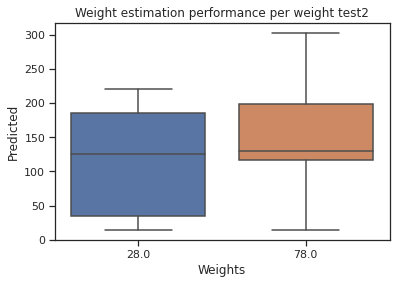

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:649: UserWarning:

Looks like the annotation(s) you are trying 
to draw lies/lay outside the given figure size.

Therefore, the resulting Plotly figure may not be 
large enough to view the full text. To adjust 
the size of the figure, use the 'width' and 
'height' keys in the Layout object. Alternatively,
use the Margin object to adjust the figure's margins.



In [ ]:
sns.set_theme(style="ticks")
fig, ax = plt.subplots()
#plt.figure(figsize=(18,10))
# Draw a nested boxplot to show bills by day and time
plot = sns.boxplot(x="Weights", y="Predicted",
            data=result_df, ax = ax)
plot.set_xlabel("Weights")
plot.set_ylabel("Predicted")
plot.set_title(f'Weight estimation performance per weight {name}')
plot.tick_params()

plt.show()
wandb.log({"Weightwise prediction": fig})


wandb.finish()

In [ ]:
plt.show()

In [ ]:
!tensorboard dev upload --logdir /content/drive/MyDrive/MS_Project/Log --name "CNN only v2 final" --description "Weight estimation using uSkin sensor data with just lift phase" 

Upload started and will continue reading any new data as it's added to the logdir.

To stop uploading, press Ctrl-C.

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/6uqTRNI2Sr6yCzwH7bZ56g/

[2022-08-12T00:18:19] Started scanning logdir.
[2022-08-12T00:18:21] Total uploaded: 0 scalars, 692 tensors (497.4 kB), 1 binary objects (47.9 kB)
Listening for new data in logdir...

Interrupted. View your TensorBoard at https://tensorboard.dev/experiment/6uqTRNI2Sr6yCzwH7bZ56g/


In [ ]:
!pip install keras-visualizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from keras_visualizer import visualizer 

In [ ]:
from keras.utils.vis_utils import plot_model

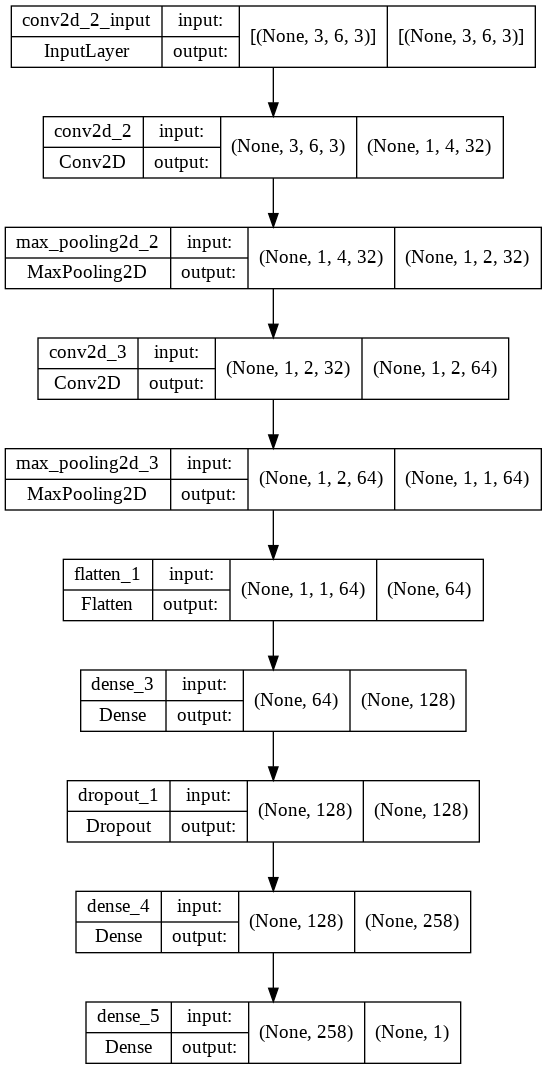

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 4.1 MB/s 


In [ ]:
import visualkeras
from PIL import ImageFont

In [ ]:
visualkeras.layered_view(model) 

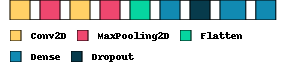

In [ ]:
from PIL import ImageFont
visualkeras.layered_view(model, legend=True, draw_volume=False) 

In [ ]:
pip install netron

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 5.2 MB/s 


In [ ]:
!pip install ann_visualizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ann-visualizer: filename=ann_visualizer-2.5-py3-none-any.whl size=4168 sha256=deba1ffdd654c90d7a1cee7e7bb0505adb4a7325319e775b58f8e1daf00d481e
  Stored in directory: /root/.cache/pip/wheels/1b/fc/58/2ab1c3b30350105929308becddda4fb59b1358e54f985e1f4a
Successfully built ann-visualizer


In [ ]:
from ann_visualizer.visualize import ann_viz
ann_viz(model)


ValueError: ignored